In [52]:
import tensorflow as tf
from time import time
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import *
from sklearn.metrics import *
from sklearn.preprocessing import *
from sklearn.pipeline import Pipeline

from tensorflow.keras import Input, Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
print(tf.python.client.device_lib.list_local_devices())

from mlxtend import evaluate, plotting

import optuna

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9083181850629291751
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 4799368957711646522
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6507127385
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14986503539442416896
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2070 SUPER, pci bus id: 0000:26:00.0, compute capability: 7.5"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 8355506563006946834
physical_device_desc: "device: XLA_GPU device"
]


In [53]:
train=pd.read_csv('fashion-mnist_train.csv')
test=pd.read_csv('fashion-mnist_test.csv')

In [54]:
y = train['label']
X = train.drop(columns='label', axis=1)
X = np.array(X / 255.0, dtype=np.float32)

y_test = test['label']
X_test = test.drop(columns='label', axis=1)
X_test = np.array(X_test / 255.0, dtype=np.float32)

X_train, X_val, y_train, y_val=train_test_split(X,y,shuffle=True,test_size=0.2)

#### output functions and plots

In [55]:
plt.rcParams['figure.figsize'] = [8, 8]
def output(model, X_train = X_train, X_test = X_test):
    y_pred =  np.argmax(model.predict(X_test), axis=1)
    
    #look at loss and accuracy scores for training and validation sets
    a=model.evaluate(X_train, y_train, verbose=0, return_dict=True)
    b=model.evaluate(X_test, y_test, verbose=0, return_dict=True)
    scores=pd.DataFrame([a, b], index=['train', 'test'])

    print(classification_report(y_test, y_pred))
    
    #make multiclass confusion matrix
    cm = evaluate.confusion_matrix(y_test, y_pred, binary=False)
    plotting.plot_confusion_matrix(conf_mat=cm)
    plt.show()
    
    #make loss and acc plots versus epochs.
    plt.subplot(2, 2, 1)
    plt.plot(r.history['loss'], label='loss')
    plt.plot(r.history['val_loss'], label='val_loss')
    plt.legend()
    plt.subplot(2, 2, 2)
    plt.plot(r.history['accuracy'], label='accuracy')
    plt.plot(r.history['val_accuracy'], label='val_accuracy')
    plt.legend()
    plt.show();
    
    return scores

#### simple NN

              precision    recall  f1-score   support

           0       0.87      0.81      0.84      1000
           1       0.98      0.98      0.98      1000
           2       0.88      0.76      0.82      1000
           3       0.91      0.91      0.91      1000
           4       0.84      0.83      0.84      1000
           5       0.97      0.95      0.96      1000
           6       0.66      0.81      0.73      1000
           7       0.95      0.92      0.93      1000
           8       0.98      0.96      0.97      1000
           9       0.93      0.97      0.95      1000

    accuracy                           0.89     10000
   macro avg       0.90      0.89      0.89     10000
weighted avg       0.90      0.89      0.89     10000



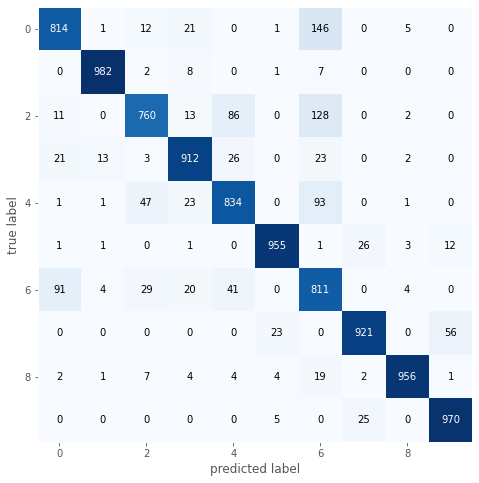

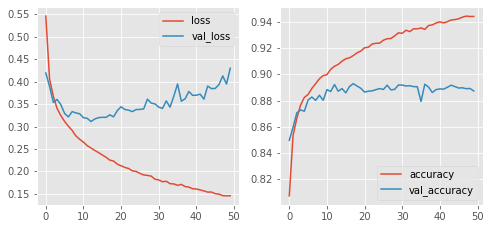

,loss,accuracy
train,0.119210,0.953812
test,0.423267,0.891500


In [52]:
model1 = Sequential()
model1.add(Dense(110, activation='relu'))
model1.add(Dropout(0.1))
model1.add(Dense(10, activation='softmax'))

model1.compile(optimizer=Adam(0.001),
              loss = 'sparse_categorical_crossentropy',
              metrics = 'accuracy')

r = model1.fit(X_train, y_train, 
           validation_data=(X_val, y_val), #validate on validation set
           epochs=50,
           verbose=0)

output(model1)

#### CNN

In [56]:
X_train_0 = X_train.reshape(-1, 28, 28, 1)
X_val_0 = X_val.reshape(-1, 28, 28, 1)
X_test_0 = X_test.reshape(-1, 28, 28, 1)

In [57]:
X_train_0.shape
X_val_0.shape
X_test_0.shape

(48000, 28, 28, 1)

(12000, 28, 28, 1)

(10000, 28, 28, 1)

In [7]:
def objective(trial):
    dropout = trial.suggest_discrete_uniform('dropout', 0.0, 0.8, 0.1)
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    optimizer = trial.suggest_categorical("optimizer", [Adam, RMSprop])
    
    conv1 = trial.suggest_int('conv1', 16, 196, step=4)
    conv2 = trial.suggest_int('conv2', 16, 196, step=4)
    conv3 = trial.suggest_int('conv3', 16, 196, step=4)
    dense_units = trial.suggest_int('dense_units', 10, 1100, step=10)
    
    model = Sequential([
    Conv2D(conv1, (3,3), activation = 'relu', input_shape=(28, 28, 1), padding='same'),
    BatchNormalization(),
    MaxPool2D(2, 2),
    Dropout(dropout),
        
    Conv2D(conv2, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPool2D(2, 2),
    Dropout(dropout),
        
    Conv2D(conv3, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPool2D(2, 2),
    Dropout(dropout),
        
    Flatten(),
    Dense(dense_units, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(dropout),
        
    Dense(10, activation='softmax')
    ])

    model.compile(optimizer=optimizer(lr),
              loss = 'sparse_categorical_crossentropy',
              metrics = 'accuracy')
    
    reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', 
                              factor = 0.5, 
                              verbose = False, 
                              patience = 4,                        
                              min_lr = 0.0001)
    
    pruning = optuna.integration.TFKerasPruningCallback(trial, 'val_accuracy')
    
    model.fit(X_train_0, y_train, 
               validation_data=(X_val_0, y_val),
               epochs=20,
               verbose=False,
               callbacks = [reduce_lr, pruning]
              )

    acc = model.evaluate(X_test_0, y_test, verbose=0, return_dict=True)['accuracy']
    
    return acc

In [8]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=40)

[I 2021-09-24 13:51:09,573] A new study created in memory with name: no-name-aefe64b9-1009-4809-b56f-547a9daacb74
[I 2021-09-24 13:53:06,632] Trial 0 finished with value: 0.850600004196167 and parameters: {'dropout': 0.6000000000000001, 'lr': 0.06537557702317966, 'optimizer': <class 'tensorflow.python.keras.optimizer_v2.rmsprop.RMSprop'>, 'conv1': 132, 'conv2': 116, 'dense_units': 820}. Best is trial 0 with value: 0.850600004196167.
[I 2021-09-24 13:54:23,379] Trial 1 finished with value: 0.7878000140190125 and parameters: {'dropout': 0.8, 'lr': 0.00034836929811594145, 'optimizer': <class 'tensorflow.python.keras.optimizer_v2.rmsprop.RMSprop'>, 'conv1': 16, 'conv2': 32, 'dense_units': 570}. Best is trial 0 with value: 0.850600004196167.
[I 2021-09-24 13:56:12,228] Trial 2 finished with value: 0.9211000204086304 and parameters: {'dropout': 0.2, 'lr': 0.0033637966241820555, 'optimizer': <class 'tensorflow.python.keras.optimizer_v2.rmsprop.RMSprop'>, 'conv1': 168, 'conv2': 36, 'dense_unit

[I 2021-09-24 14:28:51,523] Trial 34 pruned. Trial was pruned at epoch 3.
[I 2021-09-24 14:30:20,574] Trial 35 finished with value: 0.9333000183105469 and parameters: {'dropout': 0.1, 'lr': 0.003527235046927358, 'optimizer': <class 'tensorflow.python.keras.optimizer_v2.rmsprop.RMSprop'>, 'conv1': 112, 'conv2': 88, 'dense_units': 610}. Best is trial 27 with value: 0.9350000023841858.
[I 2021-09-24 14:30:26,636] Trial 36 pruned. Trial was pruned at epoch 0.
[I 2021-09-24 14:30:44,592] Trial 37 pruned. Trial was pruned at epoch 3.
[I 2021-09-24 14:31:50,761] Trial 38 pruned. Trial was pruned at epoch 18.
[I 2021-09-24 14:31:56,115] Trial 39 pruned. Trial was pruned at epoch 0.


In [9]:
trial = study.best_trial
trial.params

{'dropout': 0.1,
 'lr': 0.0006590153401915674,
 'optimizer': tensorflow.python.keras.optimizer_v2.rmsprop.RMSprop,
 'conv1': 80,
 'conv2': 96,
 'dense_units': 770}

In [58]:
model = Sequential([
    Conv2D(148, (3,3), activation = 'relu', input_shape=(28, 28, 1), padding='same'),
    BatchNormalization(),
    MaxPool2D(2, 2),
    Dropout(0.3),
    
    Conv2D(168, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPool2D(2, 2),
    Dropout(0.3),
    
    Conv2D(168, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPool2D(2, 2),
    Dropout(0.3),
    
    Flatten(),
    Dense(280, activation='relu', kernel_regularizer=l2(0.001)),
    
    BatchNormalization(),
    Dropout(0.3),
    Dense(10, activation='softmax')
])

model.summary()
model.compile(optimizer=Adam(0.0002),
              loss = 'sparse_categorical_crossentropy',
              metrics = 'accuracy')

Model: "sequential_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_126 (Conv2D)          (None, 28, 28, 148)       1480      
_________________________________________________________________
batch_normalization_168 (Bat (None, 28, 28, 148)       592       
_________________________________________________________________
max_pooling2d_126 (MaxPoolin (None, 14, 14, 148)       0         
_________________________________________________________________
dropout_168 (Dropout)        (None, 14, 14, 148)       0         
_________________________________________________________________
conv2d_127 (Conv2D)          (None, 14, 14, 168)       223944    
_________________________________________________________________
batch_normalization_169 (Bat (None, 14, 14, 168)       672       
_________________________________________________________________
max_pooling2d_127 (MaxPoolin (None, 7, 7, 168)       

In [59]:
r = model.fit(X_train_0, y_train, 
           validation_data=(X_val_0, y_val), #validate on validation set
           epochs=40,
           verbose=1)

Epoch 1/40
1500/1500 [==============================] - 7s 5ms/step - loss: 1.1414 - accuracy: 0.7571 - val_loss: 0.7800 - val_accuracy: 0.8668
Epoch 2/40
1500/1500 [==============================] - 7s 4ms/step - loss: 0.7969 - accuracy: 0.8478 - val_loss: 0.6307 - val_accuracy: 0.8892
Epoch 3/40
1500/1500 [==============================] - 7s 5ms/step - loss: 0.6539 - accuracy: 0.8666 - val_loss: 0.5132 - val_accuracy: 0.9053
Epoch 4/40
1500/1500 [==============================] - 7s 5ms/step - loss: 0.5401 - accuracy: 0.8830 - val_loss: 0.4498 - val_accuracy: 0.9022
Epoch 5/40
1500/1500 [==============================] - 7s 4ms/step - loss: 0.4579 - accuracy: 0.8935 - val_loss: 0.3738 - val_accuracy: 0.9183
Epoch 6/40
1500/1500 [==============================] - 7s 5ms/step - loss: 0.3987 - accuracy: 0.9028 - val_loss: 0.5808 - val_accuracy: 0.8418
Epoch 7/40
1500/1500 [==============================] - 7s 5ms/step - loss: 0.3590 - accuracy: 0.9081 - val_loss: 0.3313 - val_accuracy:

              precision    recall  f1-score   support

           0       0.91      0.87      0.89      1000
           1       0.99      0.99      0.99      1000
           2       0.94      0.87      0.90      1000
           3       0.94      0.96      0.95      1000
           4       0.90      0.93      0.91      1000
           5       0.99      0.98      0.99      1000
           6       0.80      0.84      0.82      1000
           7       0.97      0.96      0.96      1000
           8       0.99      0.99      0.99      1000
           9       0.96      0.98      0.97      1000

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



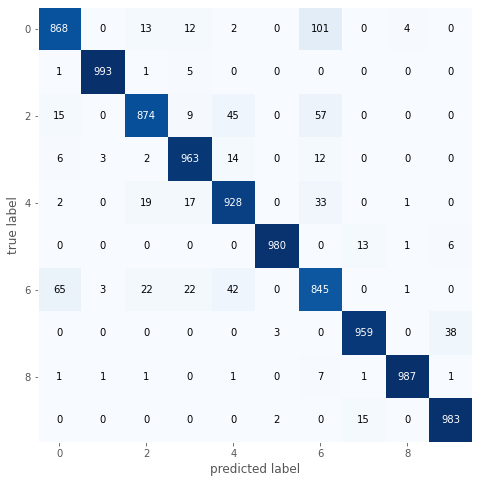

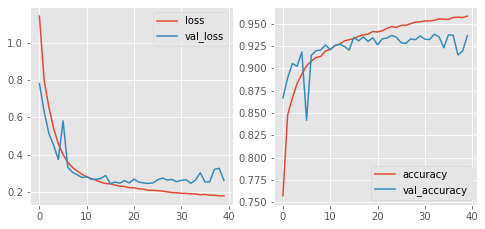

,loss,accuracy
train,0.108924,0.984958
test,0.259179,0.938000


In [60]:
output(model, X_train_0, X_test_0)

#### XGBoost

In [98]:
from xgboost import XGBClassifier

In [99]:
model = XGBClassifier(n_estimators=300, n_jobs=-1)
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=300, n_jobs=-1, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [100]:
y_pred = model.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.9117


(<Figure size 576x576 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

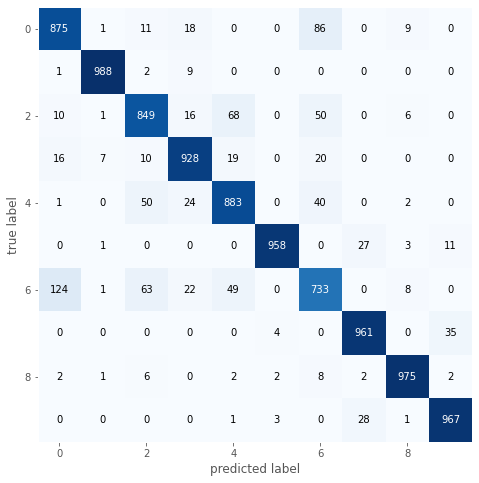

In [101]:
cm = evaluate.confusion_matrix(y_test, y_pred, binary=False)
plotting.plot_confusion_matrix(conf_mat=cm)
plt.show()